## Set Up

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras.models import Sequential
tf.random.set_seed(42)

from pyspark.sql.types import ArrayType, FloatType
import pyspark.sql.functions as F

from hyperopt import fmin, tpe, Trials, SparkTrials, hp
import mlflow
import mlflow.spark

import pandas as pd
import numpy as np
import gensim

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score, auc

import warnings
warnings.filterwarnings('ignore')

In [0]:
# Define data bucket
s3_bucket = "s3://my-ec2-storage"

## Data Preprocessing

In [0]:
# Import Drug2Vec Embedding - Morgan Fingerprints, Cosine Similarity
drug2vec_model = gensim.models.KeyedVectors.load_word2vec_format(fname=f"{s3_bucket}/weights/drug2vec_300clusters_morgan_cosine.txt", binary=False)
print('Number of drugs available:', len(drug2vec_model.index_to_key))
print('Example - top 10 keys:', drug2vec_model.index_to_key[:10])
print('Embedding dimension:', len(drug2vec_model[drug2vec_model.index_to_key[0]]))

#Import Train Set - 150K balanced
train_df = spark.read \
    .option('header', 'true') \
    .option('sep', '\t') \
    .option("inferSchema", "true") \
    .csv(f'{s3_bucket}/data/binary_ddi/ddi_train_balanced_150k.csv').toPandas()
print('Train data dimension:', train_df.shape)

# # Import Validation & Test set
val_df = spark.read \
    .option('header', 'true') \
    .option('sep', '\t') \
    .option("inferSchema", "true") \
    .csv(f'{s3_bucket}/data/binary_ddi/ddi_val_binary.csv').toPandas()
print('Validation data dimension:', val_df.shape)

test_df = spark.read \
    .option('header', 'true') \
    .option('sep', '\t') \
    .option("inferSchema", "true") \
    .csv(f'{s3_bucket}/data/binary_ddi/ddi_test_binary.csv').toPandas()
print('Test data dimension:', test_df.shape)

Number of drugs available: 2563
Example - top 10 keys: ['DB00006', 'DB00007', 'DB00014', 'DB00027', 'DB00035', 'DB00067', 'DB00080', 'DB00091', 'DB00115', 'DB00118']
Embedding dimension: 300
Train data dimension: (300000, 9)
Validation data dimension: (238072, 9)
Test data dimension: (186753, 9)


In [0]:
# Extract Embedding for Drug1 and Drug2
def get_X_y_embedding_data(df, drug2vec_model=drug2vec_model, method='Concatenate'):
    """From Drug1 & Drug2 ids, import the precalculated embeddings,
    Convert to ready data for training
    """
    # df = df_raw.copy()

    # Remove the 4 SMILES causing error, only include SMILES in drug2vec.txt
    valid_smiles = drug2vec_model.index_to_key
    df = df[df['d1'].isin(valid_smiles) & df['d2'].isin(valid_smiles)]

    # Extract embedding
    df['d1_embedding'] = df['d1'].apply(lambda x: drug2vec_model[x])
    df['d2_embedding'] = df['d2'].apply(lambda x: drug2vec_model[x])

    # Drop all records that could not extract embedding (SMILES errors)
    df = df.dropna(subset=['d1_embedding', 'd2_embedding'], how='any')
    df = df[["d1_embedding", "d2_embedding", "interaction_type", "severity"]]

    # Extract Drug1 embedding, reshape
    # d1_embed = np.stack(df['d1_embedding'].values)
    d1_embed = np.array(df['d1_embedding'].tolist())
    print('Drug1 Embedding Dimension:',d1_embed.shape)

    # d2_embed = np.stack(df['d2_embedding'].values)
    d2_embed = np.array(df['d2_embedding'].tolist())
    print('Drug2 Embedding Dimension:',d2_embed.shape)

    # Concatnate drug 1 & drug 2 embeddings
    if method == 'Difference':
        X = d1_embed - d2_embed
        print('Feature Dimension:', X.shape)

    else:
        X = np.hstack((d1_embed, d2_embed))
        print('Drug 1 Concatenate with Drug 2 Embedding Dimension:', X.shape)

    y = df['interaction_type'].values
    print('Interaction Type Label Dimension:', y.shape)

    y_severity = df['severity'].values
    y_severity = (y_severity == "high").astype('int')
    print('Interaction Severity Label Dimension:', y.shape)

    return X, y, y_severity

In [0]:
# Train Set
print("### Train Data Processing:")
X_train, y_train, y_severity_train = get_X_y_embedding_data(train_df, drug2vec_model, method='Concatenate')

### Train Data Processing:
Drug1 Embedding Dimension: (299117, 300)
Drug2 Embedding Dimension: (299117, 300)
Drug 1 Concatenate with Drug 2 Embedding Dimension: (299117, 600)
Interaction Type Label Dimension: (299117,)
Interaction Severity Label Dimension: (299117,)


In [0]:
# Val Set
print("### Val Data Processing:")
X_val, y_val, y_severity_val = get_X_y_embedding_data(val_df, drug2vec_model, method='Concatenate')

### Val Data Processing:
Drug1 Embedding Dimension: (237777, 300)
Drug2 Embedding Dimension: (237777, 300)
Drug 1 Concatenate with Drug 2 Embedding Dimension: (237777, 600)
Interaction Type Label Dimension: (237777,)
Interaction Severity Label Dimension: (237777,)


In [0]:
# Test Set
print("### Test Data Processing:")
X_test, y_test, y_severity_test = get_X_y_embedding_data(test_df, drug2vec_model, method='Concatenate')

### Test Data Processing:
Drug1 Embedding Dimension: (186487, 300)
Drug2 Embedding Dimension: (186487, 300)
Drug 1 Concatenate with Drug 2 Embedding Dimension: (186487, 600)
Interaction Type Label Dimension: (186487,)
Interaction Severity Label Dimension: (186487,)


## Training

In [0]:
def create_model(hpo):  
    model = Sequential()
    model.add(Dense(int(hpo["dense_l1"]), input_dim=600, activation="relu"))
    model.add(Dense(int(hpo["dense_l2"]), activation="relu"))
    model.add(Dense(int(hpo["dense_l3"]), activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    return model

In [0]:
# Objective Function
def run_nn(hpo):
    with mlflow.start_run():
        model = create_model(hpo)

        # Select Optimizer
        optimizer_call = getattr(tf.keras.optimizers, hpo["optimizer"])
        optimizer = optimizer_call(learning_rate=hpo["learning_rate"])

        # Compile model
        model.compile(loss="binary_crossentropy",
                    optimizer=optimizer,
                    metrics=["accuracy"])

        history = model.fit(X_train, y_train, 
                            validation_data=(X_val, y_val), 
                            batch_size=64, 
                            epochs=20, verbose=2)

        # Evaluate our model
        obj_metric = history.history["val_loss"][-1]

        # mlflow logging
        mlflow.log_metric("val_loss", obj_metric)

    return obj_metric

In [0]:
space = {
    "dense_l1": hp.quniform("dense_l1", 30, 300, 1),
    "dense_l2": hp.quniform("dense_l2", 30, 100, 1),
    "dense_l3": hp.quniform("dense_l3", 10, 50, 1),
    "learning_rate": hp.loguniform("learning_rate", -4, -2),
    "optimizer": hp.choice("optimizer", ["Adadelta", "Adam"])
 }

mlflow.tensorflow.autolog(log_models=False)

spark_trials = SparkTrials(parallelism=20)

best_hyperparam = fmin(fn=run_nn, #objective function
                       space=space, 
                       algo=tpe.suggest, 
                       max_evals=20, #total number of models built
                       trials=spark_trials,
                       rstate=np.random.default_rng(42))

best_hyperparam

Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.


100%|██████████| 20/20 [16:06<00:00, 48.31s/trial, best loss: 0.6591058373451233]


Total Trials: 20: 20 succeeded, 0 failed, 0 cancelled.


Out[10]: {'dense_l1': 68.0,
 'dense_l2': 54.0,
 'dense_l3': 40.0,
 'learning_rate': 0.0963449079278708,
 'optimizer': 0}

In [0]:
# Retrain model on train & validation dataset and evaluate on test dataset
with mlflow.start_run():   
    model = create_model(best_hyperparam)

    # Select Optimizer
    opt_value = ["Adadelta", "Adam"]
    optimizer_call = getattr(tf.keras.optimizers, opt_value[best_hyperparam["optimizer"]])
    optimizer = optimizer_call(learning_rate=best_hyperparam["learning_rate"])

    # Compile model
    model.compile(loss="binary_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])

    history = model.fit(X_train, y_train, 
                        validation_data=(X_val, y_val), 
                        batch_size=64, 
                        epochs=80, verbose=2)
    
    # Evaluate our model
    obj_metric = history.history["val_loss"][-1]
    print('loss:', obj_metric)

    # Log param and metrics for the final model
    mlflow.tensorflow.log_model(model, "NeuralNet-model")

Epoch 1/80
4674/4674 - 14s - loss: 0.6647 - accuracy: 0.5958 - val_loss: 0.6762 - val_accuracy: 0.5753 - 14s/epoch - 3ms/step
Epoch 2/80
4674/4674 - 13s - loss: 0.6458 - accuracy: 0.6242 - val_loss: 0.6743 - val_accuracy: 0.5871 - 13s/epoch - 3ms/step
Epoch 3/80
4674/4674 - 13s - loss: 0.6309 - accuracy: 0.6418 - val_loss: 0.6827 - val_accuracy: 0.6010 - 13s/epoch - 3ms/step
Epoch 4/80
4674/4674 - 13s - loss: 0.6177 - accuracy: 0.6563 - val_loss: 0.6689 - val_accuracy: 0.6046 - 13s/epoch - 3ms/step
Epoch 5/80
4674/4674 - 13s - loss: 0.6057 - accuracy: 0.6686 - val_loss: 0.6717 - val_accuracy: 0.6032 - 13s/epoch - 3ms/step
Epoch 6/80
4674/4674 - 13s - loss: 0.5952 - accuracy: 0.6795 - val_loss: 0.6862 - val_accuracy: 0.6124 - 13s/epoch - 3ms/step
Epoch 7/80
4674/4674 - 13s - loss: 0.5852 - accuracy: 0.6879 - val_loss: 0.6915 - val_accuracy: 0.6106 - 13s/epoch - 3ms/step
Epoch 8/80
4674/4674 - 13s - loss: 0.5756 - accuracy: 0.6964 - val_loss: 0.6599 - val_accuracy: 0.6259 - 13s/epoch - 3

2023/06/28 07:30:22 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


loss: 0.7345460057258606


INFO:tensorflow:Assets written to: /tmp/tmpn7umsblx/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpn7umsblx/model/data/model/assets


In [0]:
filepath = f"/dbfs/FileStore/models/keras_nn_weights_150k.ckpt"
print(filepath)
model.save(filepath)

/dbfs/FileStore/models/keras_nn_weights_150k.ckpt


INFO:tensorflow:Assets written to: /dbfs/FileStore/models/keras_nn_weights_150k.ckpt/assets


INFO:tensorflow:Assets written to: /dbfs/FileStore/models/keras_nn_weights_150k.ckpt/assets


In [0]:
# from tensorflow.keras.models import load_model
# model = load_model(filepath)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 68)                40868     
                                                                 
 dense_5 (Dense)             (None, 54)                3726      
                                                                 
 dense_6 (Dense)             (None, 40)                2200      
                                                                 
 dense_7 (Dense)             (None, 1)                 41        
                                                                 
Total params: 46,835
Trainable params: 46,835
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Predicting
y_train_pred_prob = model.predict(X_train).flatten()
y_train_pred = (y_train_pred_prob >= 0.5).astype(int).flatten()

y_val_pred_prob = model.predict(X_val).flatten()
y_val_pred = (y_val_pred_prob >= 0.5).astype(int).flatten()

y_test_pred_prob = model.predict(X_test).flatten()
y_test_pred = (y_test_pred_prob >= 0.5).astype(int).flatten()

print(y_train_pred_prob.shape)
print(y_val_pred_prob.shape)
print(y_test_pred_prob.shape)

9348/9348 [==============================] - 11s 1ms/step
 981

*** WARNING: max output size exceeded, skipping output. ***

5828/5828 [==============================] - 7s 1ms/step
(299117,)
(237777,)
(186487,)


In [0]:
def model_evaluation(y_true, y_pred, prefix="Training"):
    f2_macro =  metrics.fbeta_score(y_true, y_pred, average="binary", pos_label=1, beta=2)
    print(f"{prefix} F2-score: {round(f2_macro,4)}")

    mcc = metrics.matthews_corrcoef(y_true, y_pred)
    print(f"{prefix} Matthew Correlation Coefficient: {round(mcc,4)}")

    recall_macro = metrics.recall_score(y_true, y_pred, average="binary", pos_label=1)
    print(f"{prefix} Recall: {round(recall_macro,4)}")

    precision_macro = metrics.precision_score(y_true, y_pred, average="binary", pos_label=1)
    print(f"{prefix} Precision: {round(precision_macro,4)}")

    accuracy_macro = metrics.accuracy_score(y_true, y_pred)
    print(f"{prefix} Accuracy: {round(accuracy_macro,4)}")

# Evaluation - Macro F1 Score
model_evaluation(y_train, y_train_pred, prefix="Training")
print()
model_evaluation(y_val, y_val_pred, prefix="Validation")
print()
model_evaluation(y_test, y_test_pred, prefix="Testing")

Training F2-score: 0.8327
Training Matthew Correlation Coefficient: 0.6958
Training Recall: 0.8253
Training Precision: 0.8635
Training Accuracy: 0.8476

Validation F2-score: 0.7168
Validation Matthew Correlation Coefficient: 0.3322
Validation Recall: 0.7203
Validation Precision: 0.7031
Validation Accuracy: 0.6722

Testing F2-score: 0.7281
Testing Matthew Correlation Coefficient: 0.3044
Testing Recall: 0.7156
Testing Precision: 0.7829
Testing Accuracy: 0.6772


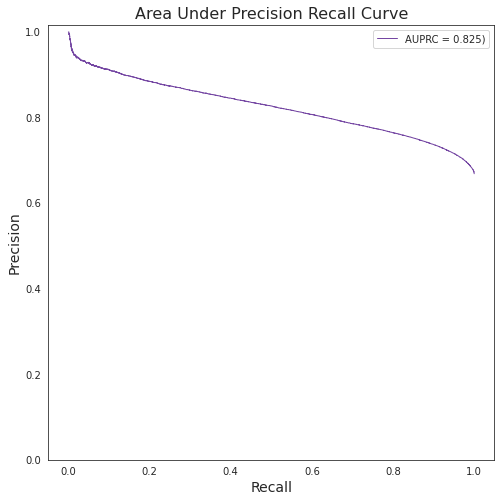

In [0]:
# Extract AUPRC & AP
from sklearn.metrics import auc

def plot_AUPRC(y_true, y_score, title='Area Under Precision Recall Curve'):
    sns.set_style('white')
    plt.figure(figsize=(8,8))

    # Compute precision-recall pairs
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    # Compute AUPRC
    auprc = auc(recall, precision)
    plt.plot(recall, precision, color="#663399", lw=1, alpha=0.9,
             label=f'AUPRC = {round(auprc, 3)})'
             )
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.ylim(bottom=0)
    plt.title(title, fontsize=16)
    plt.legend()
    plt.show()

plot_AUPRC(y_test, y_test_pred_prob)

In [0]:
target_names = ['class ' + str(x) for x in range(2)]
val_classification_report = classification_report(y_test, y_test_pred, target_names=target_names)
print("Validation Set - Classification Report:")
print(val_classification_report)

Validation Set - Classification Report:
              precision    recall  f1-score   support

     class 0       0.51      0.60      0.55     61798
     class 1       0.78      0.72      0.75    124689

    accuracy                           0.68    186487
   macro avg       0.65      0.66      0.65    186487
weighted avg       0.69      0.68      0.68    186487



In [0]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
conf_matrix = conf_matrix/conf_matrix.sum(axis=1, keepdims=True) * 100 #Convert to percentage
conf_matrix

Out[28]: array([[59.96796013, 40.03203987],
       [28.43875562, 71.56124438]])

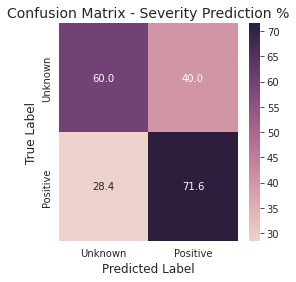

In [0]:
def plot_conf_matrix_high(conf_matrix):
    """Plot confusion matrix"""
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.heatmap(
        conf_matrix, annot=True,
        cmap=sns.cubehelix_palette(as_cmap=True),
        xticklabels= ['Negative', 'Positive'],
        yticklabels= ['Negative', 'Positive'],
        fmt='.1f'
    )
    ax.set_xlabel("Predicted Label", fontsize=12)
    ax.set_ylabel("True Label", fontsize=12)
    ax.set_title("Confusion Matrix - Interaction Prediction %", fontsize=14)
    plt.show()

plot_conf_matrix_high(conf_matrix)